# Question Answering

I Nyoman Switrayana - 23520046

Made Raharja Surya Mahadi - 23520022

Rossevine Artha Nathasya - 23520016

In [1]:
!pip install sentence_transformers

     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 2.1MB 13.2MB/s 
     |████████████████████████████████| 1.2MB 53.5MB/s 
     |████████████████████████████████| 870kB 48.6MB/s 
     |████████████████████████████████| 3.3MB 47.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-cp37-none-any.whl size=114307 sha256=f588fe70fa6804c13c0a7a489c516b9688bedacba233dc72d4f80827d57aeb9a
  Stored in directory: /root/.cache/pip/wheels/26/ea/89/d0d2e013d951b6d23270aa9ca4018b82632ab7cd933c331316
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=8b2c8da1d4d2b2336bc8f93ade0f3383f6462dc36c7f6613aeb4a0ddbf8805e3
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sentence-transformers sacremoses


# Import Library

In [2]:
import tensorflow as tf
import json
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import time
import os
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util

# Initialize Global Variable

In [3]:
# load dataset
base_dir = "drive/MyDrive/Tugas/NLP/QA/"
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# Preprocessing

## Sentence Preprocessing

In [4]:
def preprocess_sentence(w, with_start_end=True, max_length=None):
  # creating a space between a word and the punctuation following it
  w = w.lower()
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿0-9]+", " ", w)

  # find all numbers
  numbers = re.findall(r"\d+", w)

  # replace number to <number>
  w = re.sub(r"\d+", "<number>", w)
  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  if max_length is not None:
    words = w.split(' ')
    if len(words) > max_length:
      words = words[:max_length]
    w = " ".join(words)
  if with_start_end:
    w = '<start> ' + w + ' <end>'

  return w, numbers

In [4]:
preprocess_sentence("anyone who can document their qualifications and research 1 2 3 needs.")

('<start> anyone who can document their qualifications and research <number> <number> <number> needs . <end>',
 ['1', '2', '3'])

## Create Dataset From JSON

In [5]:
# 1. concat question and selected sentence
# 2. return sentence pairs in the format (question, answer, numbers)
def create_dataset(base_dir):
  with open(base_dir+"coqa-train-v1.0.json", "r") as file:
    train = json.loads(file.read())
  
  quests = []
  anss = []
  sentences = []
  numbers_input = []
  numbers_output = []
  for data in train["data"]:
    questions = data["questions"]
    answers = data["answers"]
    story = data["story"]
    sents = sent_tokenize(story)
    for s in sents:
      ss, _ = preprocess_sentence(s)
      sentences.append(ss)
    for q, a in zip(questions, answers):
      # concat question and selected sentence with <sep> separator
      input_text, num1 = preprocess_sentence(q["input_text"], False)
      span_text, num2 = preprocess_sentence(a["span_text"], False)
      quest = input_text + ' <sep> ' + span_text
      quest = '<start> ' + quest + ' <end>'

      ans, num3 = preprocess_sentence(a["input_text"], max_length=10)
      quests.append(quest)
      anss.append(ans)

      sentences.append(quest)
      ans, _ = preprocess_sentence(a["input_text"])
      sentences.append(ans)

      num = num1 + num2
      numbers_input.append(num)
      numbers_output.append(num3)

  return quests, anss, sentences, numbers_input, numbers_output
  

In [ ]:
questions, answers, sentences, numbers_input, numbers_output = create_dataset(base_dir)
print(questions[0])
print(answers[0])

<start> when was the vat formally opened ? <sep> formally established in <number> <end>
<start> it was formally established in <number> <end>


In [ ]:
len(questions), len(answers), len(numbers_input), len(numbers_output)

(108647, 108647, 108647, 108647)

## Create Label For Number

In [6]:
def create_number_label(numbers_input, numbers_output, answers, output_size):
  # find max length
  max_length_input = 0
  max_length_output = 0
  for a, b in zip(numbers_input, numbers_output):
    max_length_input = max(len(a), max_length_input)
    max_length_output = max(len(b), max_length_output)

  numbers_labels = np.zeros((len(numbers_input), output_size, max_length_input))
  for i, (inp, out, ans) in enumerate(zip(numbers_input, numbers_output, answers)):
    # cek apakah di jawaban ini ada angka
    if len(out) > 0:
      # cari angka ada di index ke berapa
      k = 0
      for j, a in enumerate(ans.split(' ')):
        if a == '<number>':
          # berarti ini number ke-k
          # cari number ke-k ada di indeks ke berapa di input
          if out[k] in inp:
            idx = inp.index(out[k])
            numbers_labels[i][j][idx] = 1

  return numbers_labels

In [ ]:
numbers_labels = create_number_label(numbers_input, numbers_output, answers, 12)
print(numbers_labels.shape)

(108647, 12, 27)


In [ ]:
questions[0], answers[0]

('<start> when was the vat formally opened ? <sep> formally established in <number> <end>',
 '<start> it was formally established in <number> <end>')

In [ ]:
numbers_labels[0][6]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Tokenizer

In [7]:
def create_tokenizer(lang):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(lang)
  return tokenizer

def tokenize(tokenizer, texts):
  tensor = tokenizer.texts_to_sequences(texts)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor

## Load Dataset

In [8]:
def load_dataset(base_dir):
  questions, answers, sentences, numbers_input, numbers_output = create_dataset(base_dir)

  tokenizer = create_tokenizer(sentences)
  input_tensor = tokenize(tokenizer, questions)
  target_tensor = tokenize(tokenizer, answers)
  numbers_labels = create_number_label(numbers_input, numbers_output, answers, target_tensor.shape[1])

  return input_tensor, target_tensor, tokenizer, numbers_labels

In [9]:
input_tensor, target_tensor, tokenizer, numbers_labels = load_dataset(base_dir)
# calculate max_length ot the target tensors
max_length_targ, max_length_inp, max_length_number = target_tensor.shape[1], input_tensor.shape[1], numbers_labels.shape[-1]

In [10]:
print("max target:", max_length_targ)
print("max input:", max_length_inp)
print("max number:", max_length_number)

max target: 12
max input: 412
max number: 27


In [11]:
numbers_labels.shape, input_tensor.shape

((108647, 12, 27), (108647, 412))

## Split Train and Test

In [10]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val, numbers_train, numbers_val = train_test_split(input_tensor, target_tensor, numbers_labels, test_size=0.2, random_state=100)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

86917 86917 21730 21730


## Show Index - Token Pair

In [ ]:
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print(f'{t} ----> {lang.index_word[t]}')

print("Input Language; index to word mapping")
convert(tokenizer, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(tokenizer, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
36 ----> how
23 ----> did
15 ----> he
1645 ----> describe
19 ----> his
460 ----> playing
7 ----> <sep>
29 ----> i
173 ----> don
53 ----> t
128 ----> think
29 ----> i
392 ----> ve
258 ----> ever
455 ----> played
81 ----> my
214 ----> best
12 ----> in
3 ----> the
66 ----> first
568 ----> round
46 ----> but
18 ----> it
20 ----> s
408 ----> important
9 ----> to
151 ----> come
175 ----> through
76 ----> them
10 ----> and
151 ----> come
67 ----> up
26 ----> with
11 ----> a
126 ----> good
1112 ----> feeling
5 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
29 ----> i
173 ----> don
53 ----> t
128 ----> think
29 ----> i
392 ----> ve
258 ----> ever
455 ----> played
81 ----> my
214 ----> best
2 ----> <end>


## Create Tensorflow Dataset

In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(tokenizer.word_index)+1
vocab_tar_size = len(tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, numbers_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [12]:
example_input_batch, example_number_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape, example_number_batch.shape

(TensorShape([64, 412]), TensorShape([64, 12]), TensorShape([64, 12, 27]))

# Models

## Encoder

In [13]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [14]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape)

Encoder output shape: (batch size, sequence length, units) (64, 412, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [14]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  15427072  
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
Total params: 19,365,376
Trainable params: 19,365,376
Non-trainable params: 0
_________________________________________________________________


## Bahdanau Attention

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [16]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 412, 1)


## Decoder

In [17]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [18]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, sample_decoder_hidden, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)
print('Decoder hidden shape: (batch_size, hidden size)', sample_decoder_hidden.shape)

Decoder output shape: (batch_size, vocab size) (64, 60262)
Decoder hidden shape: (batch_size, hidden size) (64, 1024)


In [25]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  15427072  
_________________________________________________________________
gru_1 (GRU)                  multiple                  7084032   
_________________________________________________________________
dense_3 (Dense)              multiple                  61768550  
_________________________________________________________________
bahdanau_attention_1 (Bahdan multiple                  2100225   
Total params: 86,379,879
Trainable params: 86,379,879
Non-trainable params: 0
_________________________________________________________________


## Number Decoder

In [19]:
class NumberDecoder(tf.keras.Model):
  def __init__(self, number_size):
    super(NumberDecoder, self).__init__()
    self.nn1 = tf.keras.layers.Dense(1024, activation='relu')
    self.nn2 = tf.keras.layers.Dense(512, activation='relu')
    self.nn3 = tf.keras.layers.Dense(64, activation='relu')
    self.nn4 = tf.keras.layers.Dense(number_size, activation='sigmoid')

  def call(self, hidden_state):
    x = self.nn1(hidden_state)
    x = self.nn2(x)
    x = self.nn3(x)
    x = self.nn4(x)
    return x

In [20]:
number_decoder = NumberDecoder(max_length_number)
sample_number_output = number_decoder(sample_decoder_hidden)

print("Number Decoder Output shape:", sample_number_output.shape)

Number Decoder Output shape: (64, 27)


In [28]:
number_decoder.summary()

Model: "number_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              multiple                  1049600   
_________________________________________________________________
dense_8 (Dense)              multiple                  524800    
_________________________________________________________________
dense_9 (Dense)              multiple                  32832     
_________________________________________________________________
dense_10 (Dense)             multiple                  1755      
Total params: 1,608,987
Trainable params: 1,608,987
Non-trainable params: 0
_________________________________________________________________


# Training

## Training Parameters

In [21]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

loss_number = tf.keras.losses.BinaryCrossentropy()


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

def loss_number_function(real, pred):
  return loss_number(real, pred)

## Checkpoints

In [22]:
checkpoint_dir = base_dir + 'training_checkpoints_with_number'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder,
                                 number_decoder=number_decoder)

## Train Step Function

In [23]:
@tf.function
def train_step(inp, targ, nums, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      predictions_numbers = number_decoder(dec_hidden)

      loss += loss_function(targ[:, t], predictions)
      loss += loss_number_function(nums[:, t], predictions_numbers)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables + number_decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

## Restore Checkpoint

In [24]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Train The Models

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, nums, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, nums, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

  print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
  print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 0.0959
Epoch 1 Batch 100 Loss 0.1017
Epoch 1 Batch 200 Loss 0.0743
Epoch 1 Batch 300 Loss 0.0700
Epoch 1 Batch 400 Loss 0.1028
Epoch 1 Batch 500 Loss 0.1171
Epoch 1 Batch 600 Loss 0.0839
Epoch 1 Batch 700 Loss 0.0736
Epoch 1 Batch 800 Loss 0.0991
Epoch 1 Batch 900 Loss 0.0777
Epoch 1 Batch 1000 Loss 0.1214
Epoch 1 Batch 1100 Loss 0.0696
Epoch 1 Batch 1200 Loss 0.0933
Epoch 1 Batch 1300 Loss 0.1014
Epoch 1 Loss 0.0840
Time taken for 1 epoch 1432.21 sec



## Save Checkpoints

In [ ]:
checkpoint.save(file_prefix=checkpoint_prefix)

'drive/MyDrive/Tugas/NLP/QA/training_checkpoints_with_number/ckpt-2'

# Testing

In [ ]:
# load model
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Evaluate Function

In [25]:
def evaluate(question, story):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    # concatenate question and story
    question, num1 = preprocess_sentence(question, False)
    span, num2 = preprocess_sentence(story, False)
    sentence = question + ' <sep> ' + span
    sentence = '<start> ' + sentence + ' <end>'

    numbers = num1 + num2
    # print('Numbers:', numbers)

    inputs = [tokenizer.word_index[i] for i in sentence.split(' ') if i in tokenizer.word_index]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        word = tokenizer.index_word[predicted_id]
        if predicted_id == tokenizer.word_index['<number>'] or predicted_id == tokenizer.word_index['<number>th']:
          predicted_numbers = number_decoder(dec_hidden)
          number_index = tf.argmax(predicted_numbers[0]).numpy()
          # print('Predicted numbers:', number_index)
          if number_index < len(numbers):
            word = numbers[number_index]
          if predicted_id == tokenizer.word_index['<number>th']:
            word += "th"

        result += word + ' '

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

## Plot Attention Function

In [26]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

## Find Answer

In [27]:
def find_answer(question, story):
    
    result, sentence, attention_plot = evaluate(question, story)

    print("Question:", question)
    print("Selected Sentence:", story)
    # print('Input:', sentence)
    print('Predicted answer:', " ".join(result.split(" ")[:-2]))

    sep = sentence.split(' ').index('<sep>')
    attention_plot = attention_plot[:len(result.split(' ')),
                                      sep+1:len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' ')[sep+1:], result.split(' '))

In [ ]:
question = ""
paragraph = ""
find_answer(question, paragraph)

## Find Answer From Full Paragraph

In [29]:
# find answer from full sentence
def find_answer_from_story(question, story, k=3):
  # Load Sentence Embedding
  context_encoder = SentenceTransformer('facebook-dpr-ctx_encoder-multiset-base')
  question_encoder = SentenceTransformer('facebook-dpr-question_encoder-multiset-base')
  # calculate question embedding
  question_embedding = question_encoder.encode(question)
  # split story by sentences
  sentences = sent_tokenize(story)
  # calculate stories embedding
  story_embedding = context_encoder.encode(sentences)
  # calculate similarities
  similarities = util.pytorch_cos_sim(question_embedding, story_embedding).numpy()
  # sort similarities
  sorted_arg = np.argsort(similarities, axis=-1)[0][::-1]
  # take top-k sentences and feed to find_answer
  for i in sorted_arg[:k]:
    selected_sentence = sentences[i]
    find_answer(question, selected_sentence)

Question: where will he visit ?
Selected Sentence: Benedict is due to visit England and Scotland from September 16-19.
Predicted answer: england


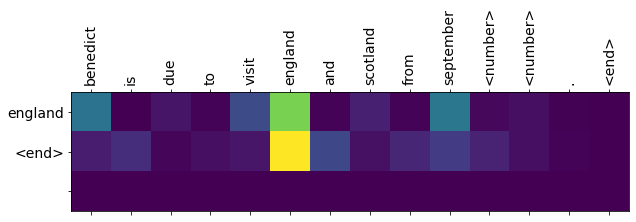

Question: where will he visit ?
Selected Sentence: After the final hymn at the end of the Mass, Boyle will sing a farewell song to the pope as he leaves to go to the airport for his flight to London, the church said.
Predicted answer: the united


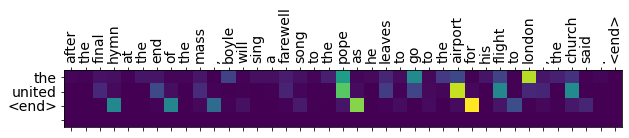

Question: where will he visit ?
Selected Sentence: "I think the 16th of September will stand out in my memory as something I've always wanted to do.
Predicted answer: the long island


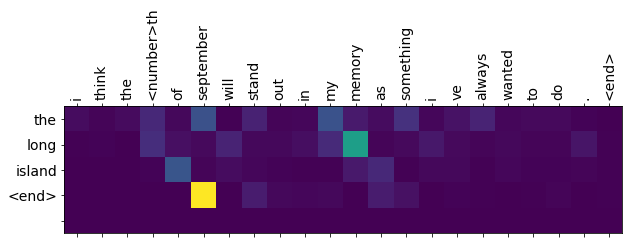

In [36]:
question = "where will he visit ?"
story = "London, England (CNN) -- TV talent show star Susan Boyle will sing for Pope Benedict XVI during his visit to Scotland next month, the Catholic Church in Scotland said Wednesday. \n\nA church spokesman said in June they were negotiating with the singing phenomenon to perform. \n\nBenedict is due to visit England and Scotland from September 16-19. \n\nBoyle will perform three times at Bellahouston Park in Glasgow on Thursday, Sept. 16, the Scottish Catholic Media Office said. She will also sing with the 800-strong choir at the open-air Mass there. \n\nIn the pre-Mass program, Boyle plans to sing the hymn \"How Great Thou Art\" as well as her signature song, \"I Dreamed a Dream,\" the tune from the musical \"Les Miserables\" that shot her to fame in April 2009. \n\n\"To be able to sing for the pope is a great honor and something I've always dreamed of -- it's indescribable,\" Boyle, a Catholic, said in a statement. \"I think the 16th of September will stand out in my memory as something I've always wanted to do. I've always wanted to sing for His Holiness and I can't really put into words my happiness that this wish has come true at last.\" \n\nBoyle said her late mother was at the same Glasgow park when Pope John Paul II visited in 1982. \n\nAfter the final hymn at the end of the Mass, Boyle will sing a farewell song to the pope as he leaves to go to the airport for his flight to London, the church said. "
find_answer_from_story(question, story, k=3)

# Evaluate

## Install BLEU

In [31]:
# calculate BLEU score
!pip install bleu

  Created wheel for bleu: filename=bleu-0.3-cp37-none-any.whl size=5802 sha256=52c1ebde98db5e5b4cb0552d810e0603cd3740d24b30479c2e22c61a3de63ac1
  Stored in directory: /root/.cache/pip/wheels/a9/95/e7/cb43a1c509c38fedbee6223963e34a51a94d8991f3b3e1888e
  Created wheel for efficiency: filename=efficiency-0.5-cp37-none-any.whl size=20285 sha256=49433ed04a3eb817a7a0208d3ca6690fa40b55eec769c068345aa8f8727df791
  Stored in directory: /root/.cache/pip/wheels/94/fd/e6/2d34e80768fb2d001fc35b033a48114b1afdb6ea020b4cb2c7
Successfully built bleu efficiency


## Import BLEU

In [53]:
import tqdm
from bleu import list_bleu

## Create Predictions

In [59]:
# create predicted answer and real answer pair
references = []
hypothesis = []
with tqdm.tqdm(total=len(input_tensor_val), position=0, leave=True) as pbar:
  for i in tqdm.tqdm(range(len(input_tensor_val)), position=0, leave=True):
    X_val, y_val = input_tensor_val[i], target_tensor_val[i]
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(tf.convert_to_tensor([X_val]), hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                          dec_hidden,
                                                          enc_out)

        predicted_id = tf.argmax(predictions[0]).numpy()

        word = tokenizer.index_word[predicted_id]
      
        if word == '<end>':
          break

        result += word + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    result = result[:-1] # remove last space
    # create validation output
    real = ''
    for y in y_val[1:]:
      if y == 0:
        break
      word = tokenizer.index_word[y]
      if word == '<end>':
        break
      real += word + ' '

    references.append(real)
    hypothesis.append(result)
    pbar.update()

100%|██████████| 21730/21730 [21:41<00:00, 16.69it/s]


## Calculate BLEU Score

In [75]:
# calculate BLEU SCORE
list_bleu([references], hypothesis)

74.16